# Pipeline

In [1]:
from train_pipeline import train

import os
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from hydra.utils import instantiate
from omegaconf import OmegaConf


def load_cfg(overrides=()):
    # with initialize_config_dir(config_dir="/app/notebooks/draft_02/conf"):
    with initialize(version_base=None, config_path="./conf"):
        cfg = compose(config_name='config', overrides=list(overrides))
        return cfg

from IPython.display import clear_output

cfg = load_cfg(overrides=[
    "+exp=01_splitnet_posenc",
    f"model.encoding_size={64}",
    f"model.hidden_layers={3}",
    'image=cameraman',
    'model.m=1',
    'logging.experiment_name="splitnet_posenc__nlayers=${model.hidden_layers}"',
    "+device=cuda:1",
])

print(OmegaConf.to_yaml(cfg))

image: cameraman
image_dir: ../../data
image_W: 512
use_wandb: true
is_debug: false
total_steps: 3000
random_seed:
- 0
- 1
- 2
model:
  _target_: spellbook.splitnet.SplitNetPosEnc
  in_features: 2
  encoding_size: 64
  hidden_features: 128
  hidden_layers: 3
  outermost_linear: false
  m: 1
logging:
  logger:
    _target_: spellbook.logging.wandb.WandbLogger
    project: 01_splitnet__${image}
  steps_till_summary: 500
  experiment_name: splitnet_posenc__nlayers=${model.hidden_layers}
optimizer:
  _target_: torch.optim.AdamW
  weight_decay: 0.0
  lr: 0.0001
device: cuda:1



In [2]:
cfg.model

{'_target_': 'spellbook.splitnet.SplitNetPosEnc', 'in_features': 2, 'encoding_size': 64, 'hidden_features': 128, 'hidden_layers': 3, 'outermost_linear': False, 'm': 1}

In [3]:
import rff

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os
import math
from tqdm.auto import tqdm

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time

def get_mgrid(sidelen, dim=2, device='cpu'):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen, device=device)])
    mgrid = torch.stack(torch.meshgrid(*tensors, indexing='ij'), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

import plotly.express as px
import pandas as pd

def to_np(t):
    a = t.detach().flatten().cpu().numpy()
    a = np.random.choice(a, size=1_000, replace=False)
    return a


def U(*shape, r=1):
    x = torch.rand(*shape)
    
    x = (x-0.5)*(2*r)
    return x


import lovely_tensors as lt
lt.monkey_patch()

In [4]:
from spellbook.splitnet import plot_acts

In [5]:
def init_siren(W, fan_in, omega=30, init_c=24, flic=2, is_first=False):
    if is_first:
        c = flic / fan_in
    else:
        c = np.sqrt(init_c / fan_in) / omega    
    W.uniform_(-c, c)

In [6]:
from spellbook.splitnet import plot_distributions

In [7]:
import torch
from torch import nn
import torch.nn.functional as F

import os
import math


class SplitLayerOmegas(nn.Module):
    def __init__(self, input_dim, output_dim, m=1., omegas=(1,1,1.,1)):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim * 4)
        self.m = m
        self.omegas = omegas

    def forward(self, x):
        h, acts = self.forward_with_activations(x)
        return h

    def forward_with_activations(self, x):
        preact = self.linear(x)
        preacts = preact.chunk(4, dim=-1)
        preacts = list(preacts)
    
        for i in range(len(preacts)):
            preacts[i] = self.omegas[i] * preacts[i]

        preact_tanh, preact_sigmoid, preact_sin, preact_cos = preacts
        act_tanh, act_sigmoid, act_sin, act_cos = preact_tanh.tanh(), preact_sigmoid.sigmoid(),preact_sin.sin(), preact_cos.cos()
        h = act_tanh * act_sigmoid * act_sin * act_cos
        
        h = h * self.m

        return h, [x, preact, preact_tanh, preact_sigmoid, preact_sin, preact_cos, act_tanh, act_sigmoid, act_sin, act_cos]

class SplitNetPosEncOmegas(nn.Module):
    def __init__(self, 
                 in_features=2,
                 encoding_size=64,
                 hidden_features=64, 
                 hidden_layers=1, 
                 out_features=1, 
                 outermost_linear=True,
                 m=1.,
                 omegas=(1,1,1.,1),
                 init_fn=None,
                 ):
        super().__init__()
        if not hasattr(m, '__len__'):
            m = [m] * (hidden_layers+2)
            
        is_layerwise_omegas = hasattr(omegas[0], '__len__')
        
        if not is_layerwise_omegas:
            omegas = [omegas] * (hidden_layers+2)
            

        import rff
        self.encoding = rff.layers.GaussianEncoding(sigma=10.0, input_size=in_features, encoded_size=encoding_size)
        self.net = []

        self.net += [SplitLayerOmegas(encoding_size*2, hidden_features, m=m[0], omegas=omegas[0])]
        self.net += [SplitLayerOmegas(hidden_features, hidden_features, m=m[i+1], omegas=omegas[i+1]) for i in range(hidden_layers)]

        if outermost_linear:
            self.net += [nn.Linear(hidden_features, out_features)]
        else:
            self.net += [SplitLayerOmegas(hidden_features, out_features, omegas=omegas[-1], m=m[-1])]

        self.net = nn.Sequential(*self.net)
        self.outermost_linear = outermost_linear
        self.omegas = omegas
        
        if init_fn == "my_init_02":
            my_init_02(self)
        elif init_fn == 'my_init_03':
            my_init_03(self)
        elif init_fn is not None:
            raise ArgumentError(f"Unknown init_fn: {init_fn}")

    def forward(self, x):
        x = self.encoding(x)
        return self.net(x)

    def forward_with_activations(self, x):
        x = self.encoding(x)
        h = x
        intermediate_acts = []

        for layer in self.net:
            if isinstance(layer, SplitLayerOmegas):
                h, acts = layer.forward_with_activations(h)
            else:
                h = layer(h)
                acts = []

            intermediate_acts.append((h, acts))

        return h, intermediate_acts

    


In [8]:
mega_omegas = [
    (5/1.323, 15/0.78213, 9/1.2, 10),
    (15, 5, 10, 10),
    (5, 5, 10, 10),
    (5, 5, 10, 10),
    (5, 5, 10, 10),
]

giga_omegas = [
    [0.12014468014240265, 0.6008497476577759, 0.2702421545982361, 0.2616932690143585],
    [0.5118758678436279, 1.9711511135101318, 0.7647950053215027, 0.7527167201042175],
    [2.7775514125823975, 9.462844848632812, 3.237828016281128, 3.223662853240967],
    [18.891096115112305, 60.468223571777344, 18.257936477661133, 18.576128005981445],
    [12.317709922790527, 39.97261428833008, 11.623711585998535, 11.119503021240234],
]

In [10]:
model_kwargs = {'in_features': 2, 
                'encoding_size': 64, 
                'hidden_features': 128, 
                'hidden_layers': 3, 
                'omegas': giga_omegas,
                # 'omegas': (1,1,30,30),
                'outermost_linear': False, 
                'm': 10.
}

# model = instantiate(cfg.model, out_features=1, m=[10, 10, 10,10,10])
model = SplitNetPosEncOmegas(**model_kwargs)
omegas = model.omegas



In [11]:
# layer.linear.weight.data /= 10

act_tanh (2000, 128) in [-0.223, 0.241] μ=-0.000 σ=0.049
act_sigmoid (2000, 128) in [0.216, 0.740] μ=0.500 σ=0.061
act_sin (2000, 128) in [-0.495, 0.467] μ=-0.001 σ=0.110
act_cos (2000, 128) in [0.869, 1.000] μ=0.994 σ=0.008


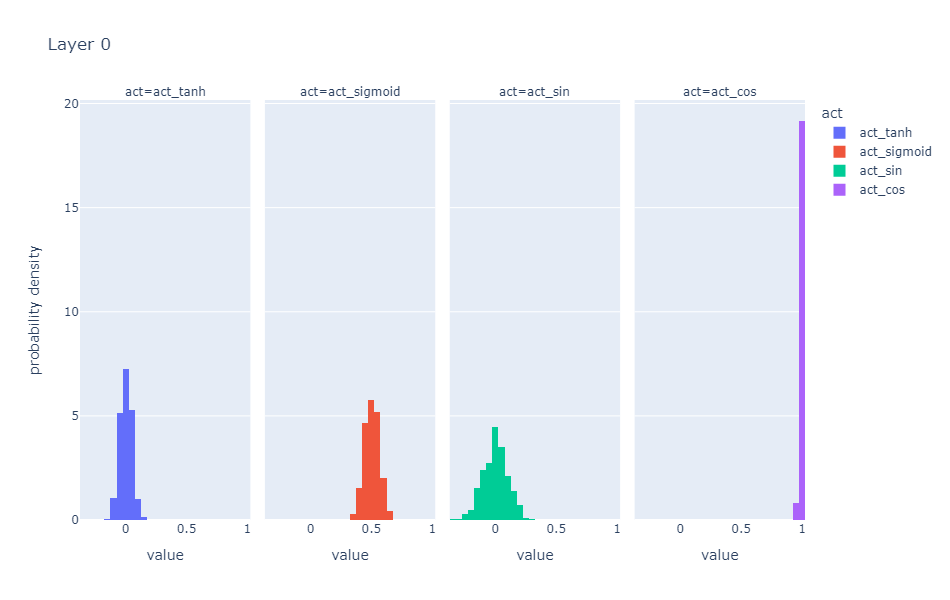

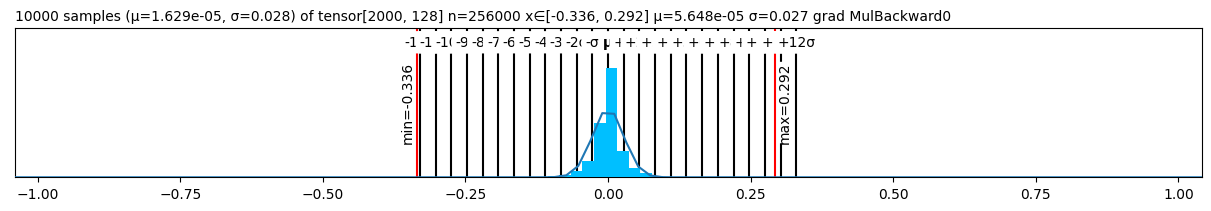

act_tanh (2000, 128) in [-0.077, 0.077] μ=0.004 σ=0.028
act_sigmoid (2000, 128) in [0.427, 0.572] μ=0.500 σ=0.028
act_sin (2000, 128) in [-0.113, 0.111] μ=0.001 σ=0.041
act_cos (2000, 128) in [0.994, 1.000] μ=0.999 σ=0.001


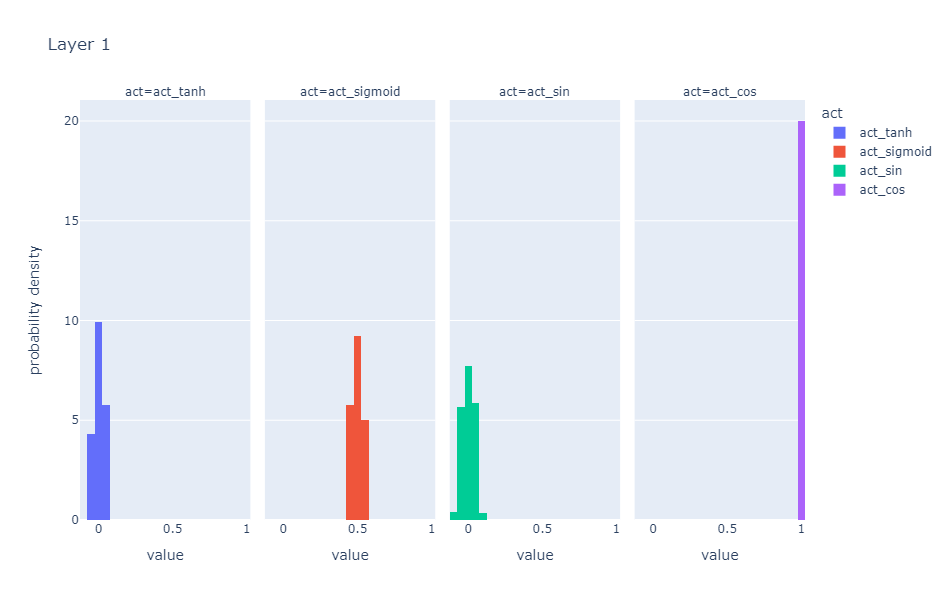

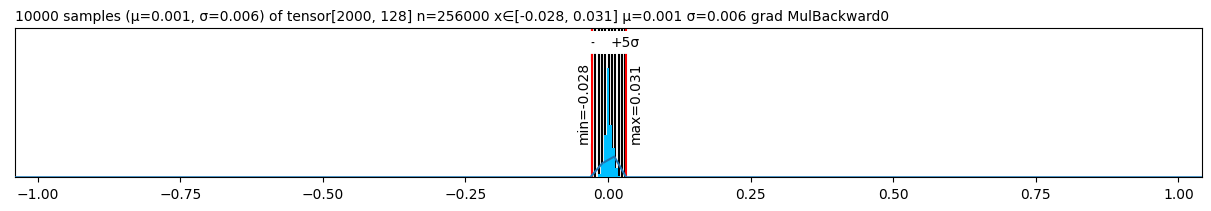

act_tanh (2000, 128) in [-0.262, 0.262] μ=0.003 σ=0.141
act_sigmoid (2000, 128) in [0.281, 0.709] μ=0.493 σ=0.115
act_sin (2000, 128) in [-0.304, 0.292] μ=0.006 σ=0.166
act_cos (2000, 128) in [0.950, 1.000] μ=0.987 σ=0.012


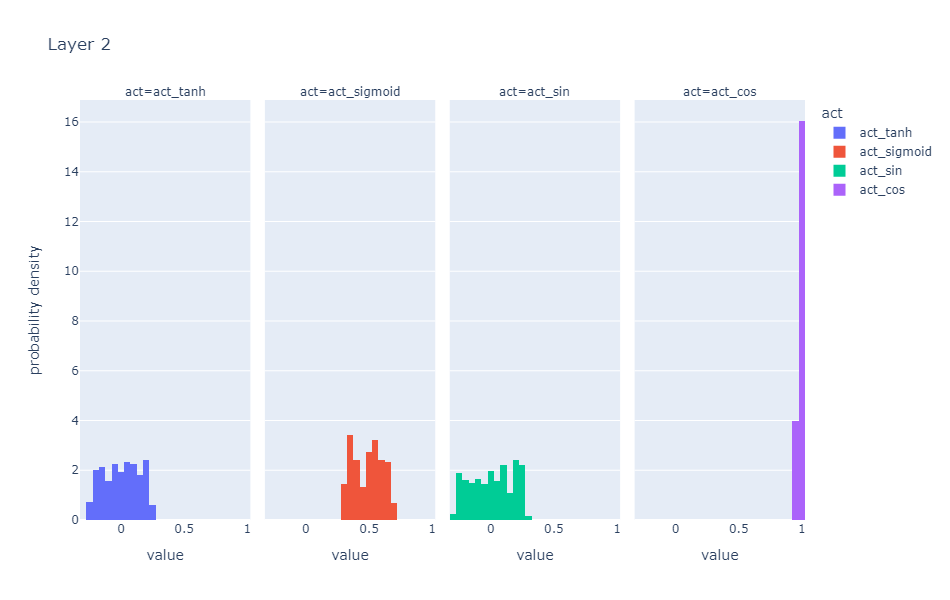

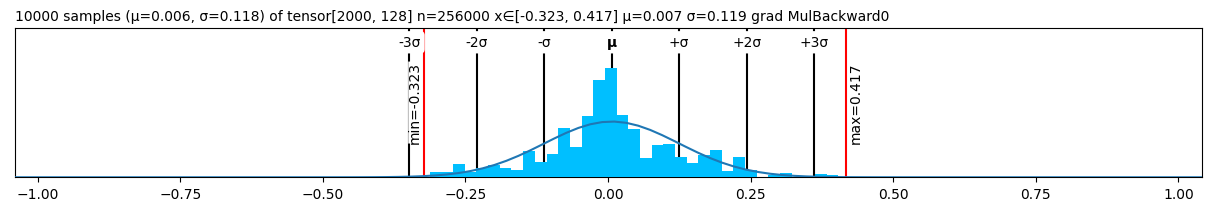

act_tanh (2000, 128) in [-1.000, 1.000] μ=-0.020 σ=0.798
act_sigmoid (2000, 128) in [0.000, 1.000] μ=0.473 σ=0.415
act_sin (2000, 128) in [-1.000, 1.000] μ=0.021 σ=0.720
act_cos (2000, 128) in [-1.000, 1.000] μ=0.233 σ=0.656


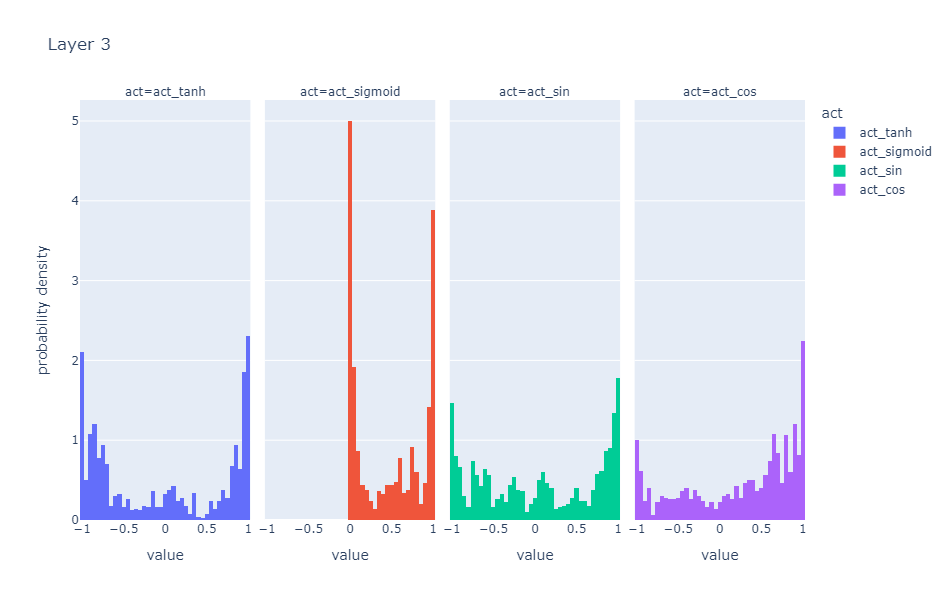

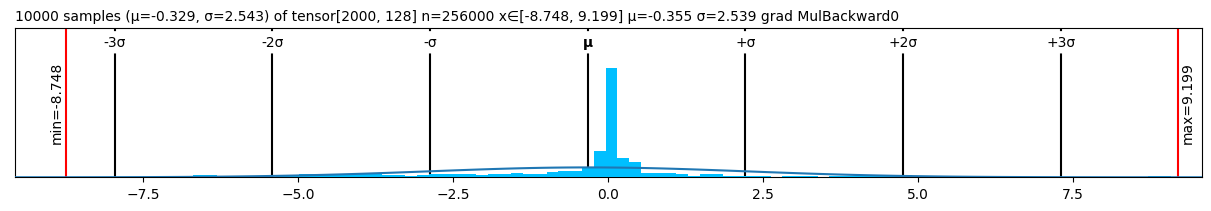

act_tanh (2000, 1) in [1.000, 1.000] μ=1.000 σ=0.000
act_sigmoid (2000, 1) in [1.000, 1.000] μ=1.000 σ=0.000
act_sin (2000, 1) in [-1.000, 1.000] μ=-0.031 σ=0.643
act_cos (2000, 1) in [-1.000, 1.000] μ=-0.131 σ=0.673


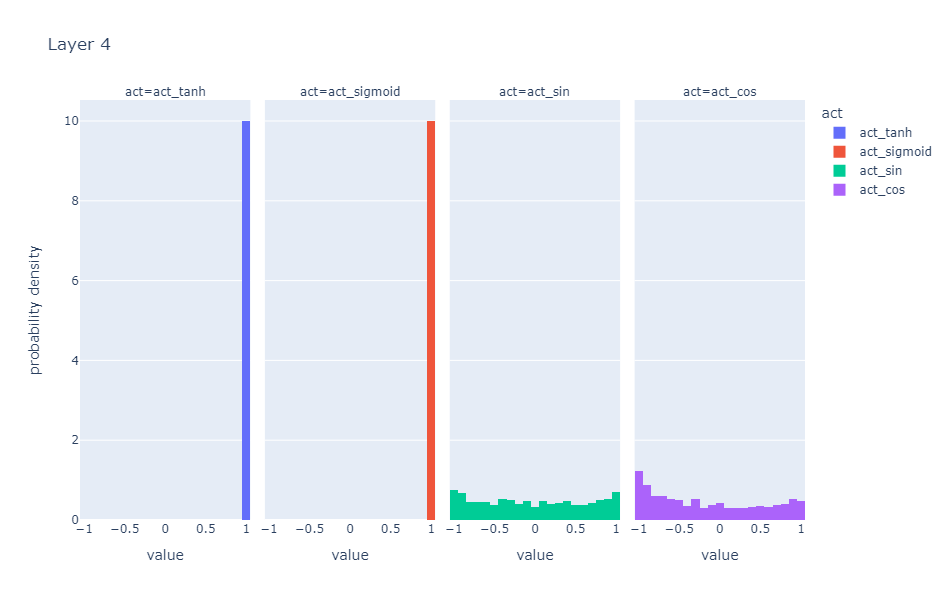

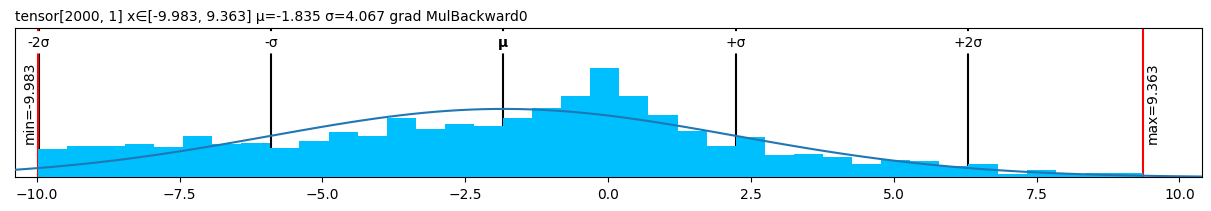

In [12]:
x = U(2000, 2)
o, intermediate_acts = model.forward_with_activations(x)

for i, (h, acts) in enumerate(intermediate_acts):
    plot_acts(acts, title=f'Layer {i}')
    display(h.plt)
    # if i >= 1:
    #     break

In [13]:
# x = U(2000, 2)
# o, intermediate_acts = model.forward_with_activations(x)

# for i, (h, acts) in enumerate(intermediate_acts):
#     plot_acts(acts, title=f'Layer {i}')
#     display(h.plt)

In [14]:
x = U(2000, 2)
o, intermediate_acts = model.forward_with_activations(x)

o.mean().backward()

In [15]:
layers = {}

for i, layer in enumerate(model.net):
    W = layer.linear.weight
    G = W.grad.detach().cpu()

    G_tanh, G_sigmoid, G_sin, G_cos = G.chunk(4, dim=0)

    proposed_omegas_layer = {
        'G_tanh': omegas[i][0] / G_tanh.std(), 
        'G_sigmoid': omegas[i][1] / G_sigmoid.std(), 
        'G_sin': omegas[i][2] / G_sin.std(), 
        'G_cos': omegas[i][3] / G_cos.std()
    }
    
    print( [v.item() for v in (proposed_omegas_layer.values())] )

[3.770108222961426, 173.92422485351562, 8.522177696228027, 782.8367919921875]
[11.166999816894531, 842.2554321289062, 15.912270545959473, 10183.5107421875]
[11.158495903015137, 142.9726104736328, 11.244662284851074, 416.5400390625]
[9.194591522216797, 51.44192123413086, 5.858299255371094, 6.629086017608643]
[4636244.5, inf, 0.40294474363327026, 0.8601976633071899]


G_tanh (128, 128) in [-0.318, 0.295] μ=-0.000 σ=0.050
G_sigmoid (128, 128) in [-0.027, 0.033] μ=0.000 σ=0.005
G_sin (128, 128) in [-0.291, 0.276] μ=-0.000 σ=0.051
G_cos (128, 128) in [-0.003, 0.003] μ=-0.000 σ=0.000


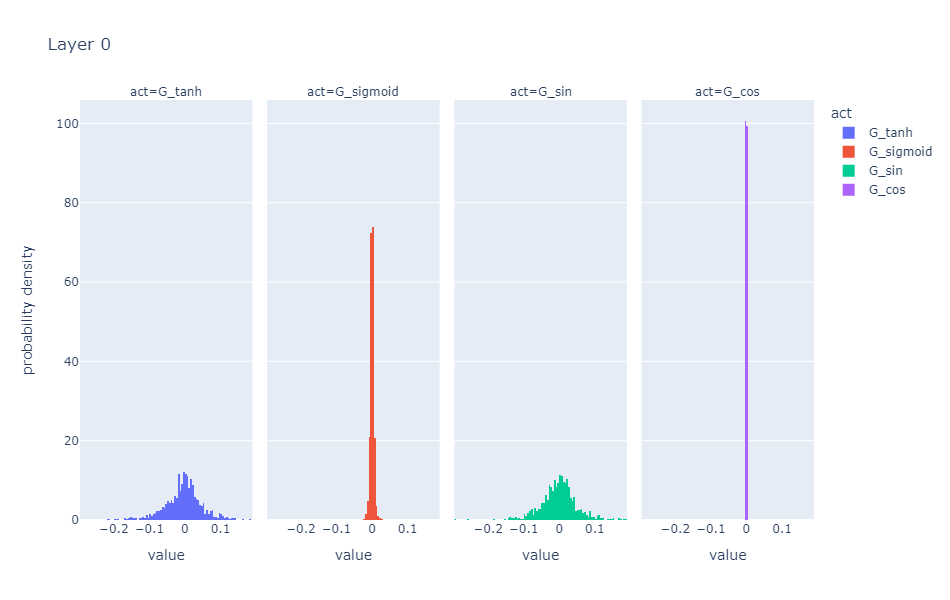

G_tanh (128, 128) in [-0.707, 0.637] μ=0.000 σ=0.086
G_sigmoid (128, 128) in [-0.046, 0.037] μ=0.000 σ=0.004
G_sin (128, 128) in [-0.660, 0.623] μ=-0.000 σ=0.092
G_cos (128, 128) in [-0.002, 0.002] μ=0.000 σ=0.000


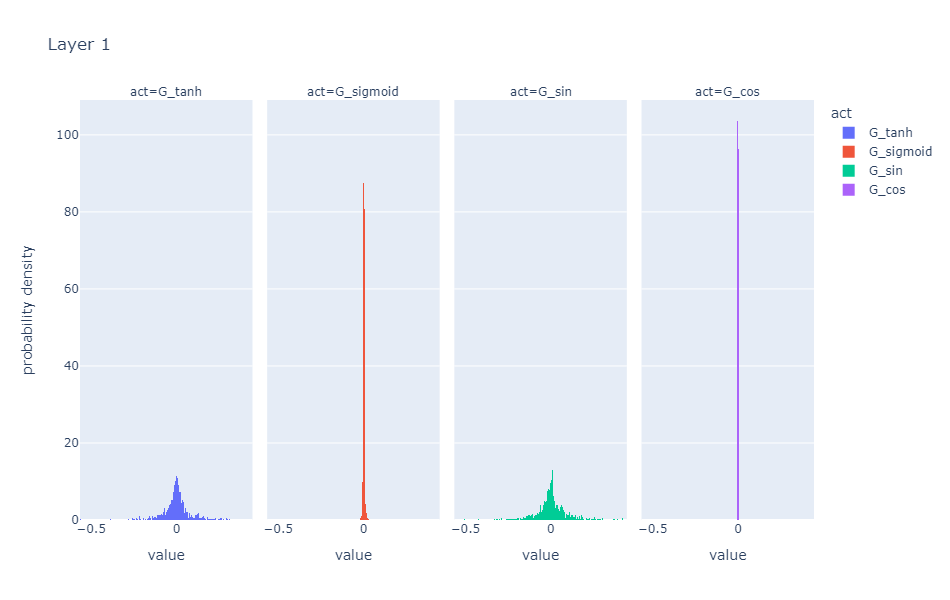

G_tanh (128, 128) in [-4.555, 3.598] μ=-0.017 σ=0.522
G_sigmoid (128, 128) in [-1.288, 1.655] μ=-0.000 σ=0.138
G_sin (128, 128) in [-4.561, 5.438] μ=0.011 σ=0.594
G_cos (128, 128) in [-0.267, 0.208] μ=-0.001 σ=0.016


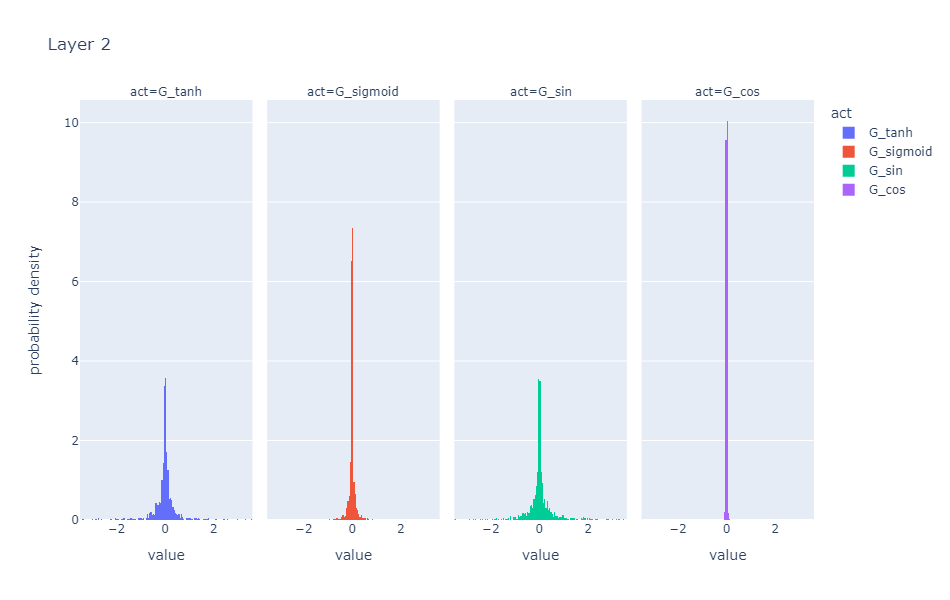

G_tanh (128, 128) in [-66.844, 83.961] μ=0.031 σ=4.275
G_sigmoid (128, 128) in [-37.667, 48.025] μ=0.001 σ=2.444
G_sin (128, 128) in [-79.336, 81.065] μ=-0.039 σ=6.443
G_cos (128, 128) in [-82.528, 69.121] μ=0.025 σ=5.874


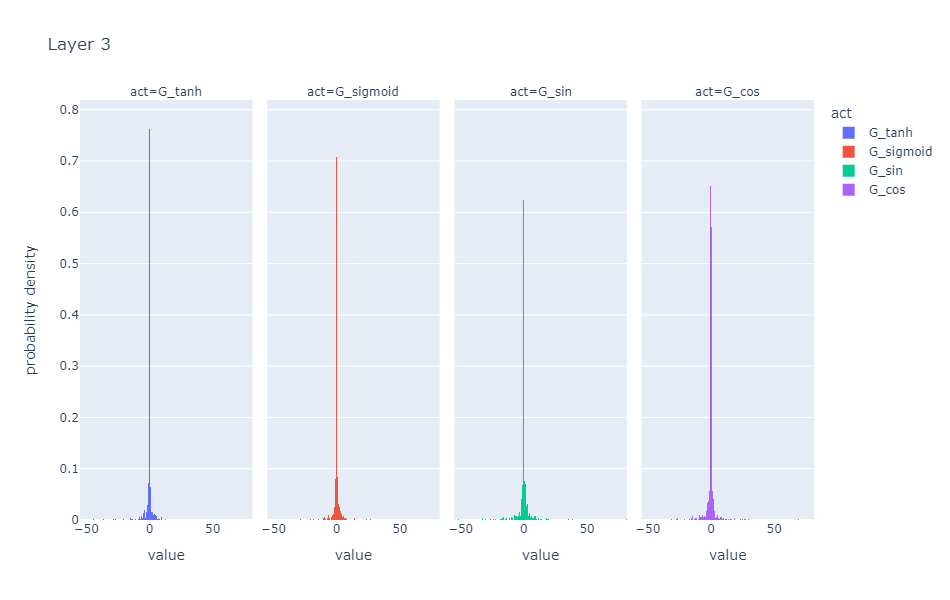

G_tanh (1, 128) in [-0.000, 0.000] μ=0.000 σ=0.000
G_sigmoid (1, 128) in [0.000, 0.000] μ=0.000 σ=0.000
G_sin (1, 128) in [-212.763, 198.047] μ=8.133 σ=60.757
G_cos (1, 128) in [-64.229, 71.969] μ=-2.623 σ=20.773


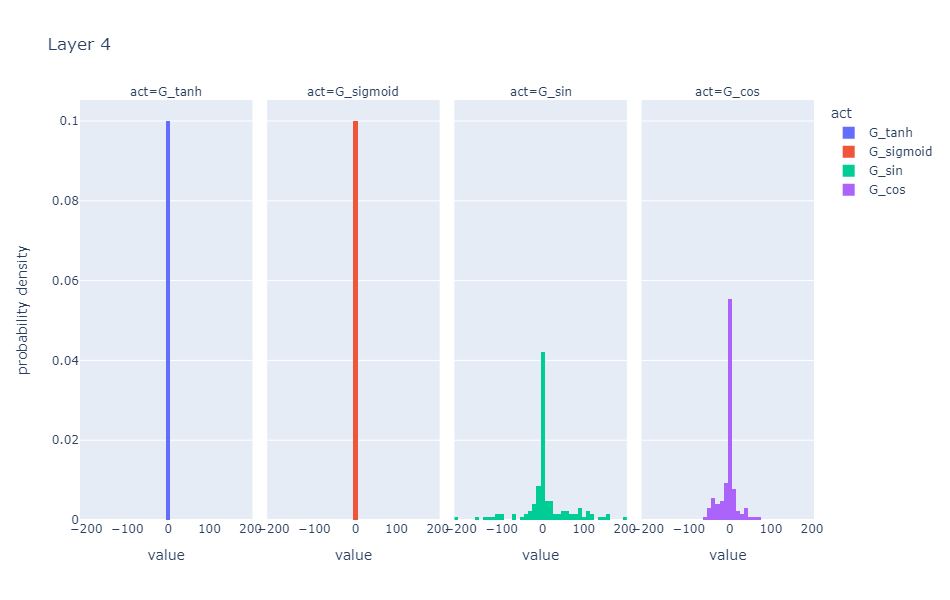

In [16]:

x = U(2000, 2)
o, intermediate_acts = model.forward_with_activations(x)

o.mean().backward()

for i, layer in enumerate(model.net):
    W = layer.linear.weight
    G = W.grad.detach().cpu()

    G_tanh, G_sigmoid, G_sin, G_cos = G.chunk(4, dim=0)

    plot_data = {
        'G_tanh': G_tanh, 
        'G_sigmoid': G_sigmoid, 
        'G_sin': G_sin, 
        'G_cos': G_cos
    }
    
    # for k,v in plot_data.items():
    #     print(k, v)
    
    plot_distributions(plot_data, title=f'Layer {i}')

    # if i >= 1:
    #     break

In [ ]:
break

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []

for i, (layer) in enumerate(model.net):
    # if i 
    W = layer.linear.weight
    # print(W.grad)
    
    G = W.grad.cpu()
    W = W.cpu()
    print('grad %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(G.shape), G.mean(), G.std(), G.std() / W.std()))
    hy, hx = torch.histogram(G, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'Layer {i} {tuple(G.shape)}')

plt.legend(legends)
plt.title('weights gradient distribution');

In [ ]:
break

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []

for i, (layer) in enumerate(model.net):
    # if i 
    W = layer.linear.weight
    # print(W.grad)
    
    G = W.grad.cpu()
    W = W.cpu()
    print('grad %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(G.shape), G.mean(), G.std(), G.std() / W.std()))
    hy, hx = torch.histogram(G, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    plt.title(f'Layer {i} {tuple(G.shape)}');
    plt.show()


In [ ]:
break

In [ ]:
x_enc = model.encoding(x)
x_enc

In [ ]:
fan_in = 128

In [ ]:
omega=30
init_c=24
flic=2

c = np.sqrt(init_c / fan_in) / omega

In [ ]:
W = torch.zeros(fan_in, fan_in)
W.uniform_(-c, c)
W.plt

In [ ]:
(x_enc@(W*omega)).sin().plt

In [ ]:
acts = intermediate_acts[0]
x, preact, preact_tanh, preact_sigmoid, preact_sin, preact_cos, act_tanh, act_sigmoid, act_sin, act_cos = acts[1]

In [ ]:
act_sin.plt

In [ ]:
o.plt

In [ ]:
for i, (h, acts) in enumerate(intermediate_acts):
    plot_acts(acts, title=f'Layer {i}')
    display(h.plt)
    
